# Correlated Cross-Frequency Noise at Low Frequencies

One important finding of the spectral analysis of LIGO Haneford data was that noise levels seemed to be strongly correlated across lower frequencies, as seen by the vertical lines that dominate the low-frequency end of the spectrograms:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries

# Getting data
min_time1 = 1263097420
max_time1 = 1263098020
hdata1 = TimeSeries.fetch_open_data('H1', min_time1, max_time1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


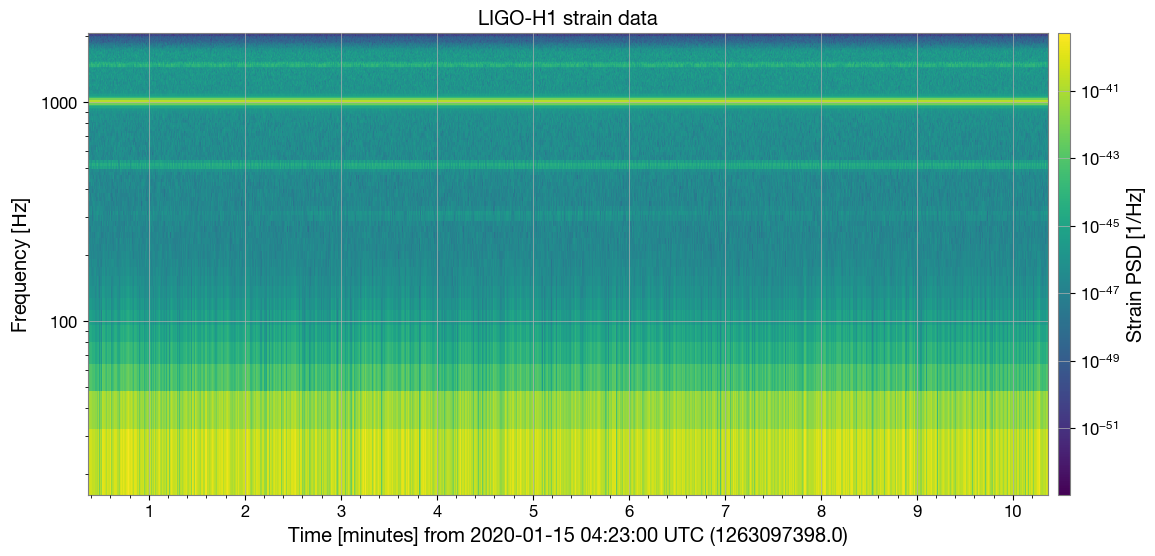

In [2]:
spectrogram = hdata1.spectrogram2(fftlength=1/16., overlap=15/256.)
plot = spectrogram.plot(norm='log', cmap='viridis', yscale='log')
ax = plot.gca()
ax.set_title('LIGO-H1 strain data')
ax.colorbar(label=r'Strain PSD [1/Hz]')
plot.show()

How do these correlate across frequencies? Are these really so similar? Looking at the spectrogram, from 1 to 100 Hz frequency bins start at multiples of 16 due to `fftlength = 16`.

In [3]:
# A function for making a frequency-specific strain time series
# When chosing a frequency, keep in mind the trade-off between frequency resolution and time resolution
# The available frequencies will be multiples of the 1/fftlength; however, they may not be proper
# integer multiples; chose an even power of two in order to get integer frequencies.
def freq_specific_time_series(data, start_time, analysis_length, dt, max_time, freq, fftlength=1/16.):
    lower = start_time
    upper = lower + analysis_length
    values = []
    while (upper <= max_time):
        slice = data.crop(lower, upper)
        psd = slice.psd(fftlength=fftlength)
        values += [psd.value_at(freq).value]
        lower += dt
        upper += dt
    return TimeSeries(values, None, start_time + analysis_length / 2, dt)

In [4]:
def plot_fss_at_freq(frequency):
    fss = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, frequency)
    plot1 = fss.plot()
    ax1 = plot1.gca()
    ax1.set_title(f'LIGO H1 Frequency-Specific Time Series at {frequency} Hz')
    plot1.show()

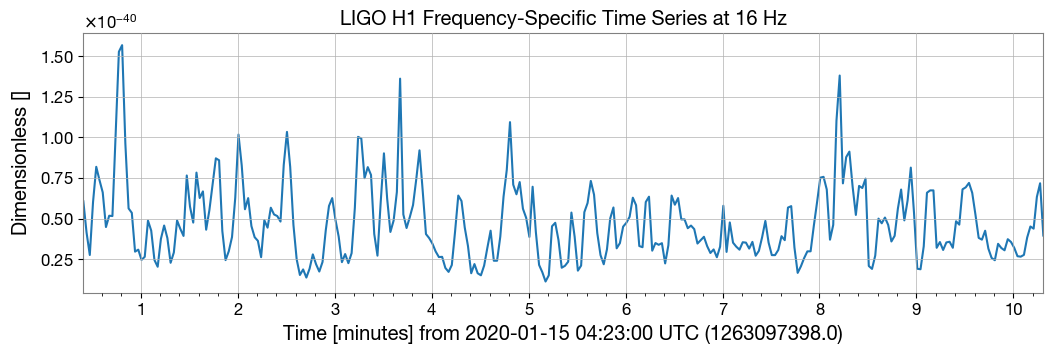

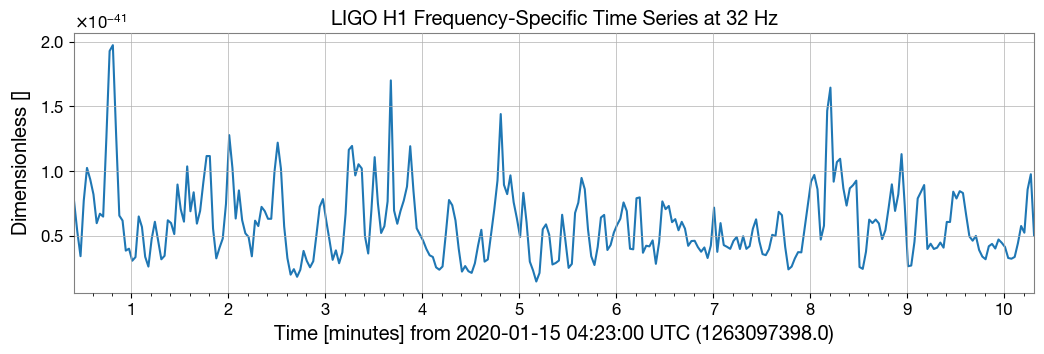

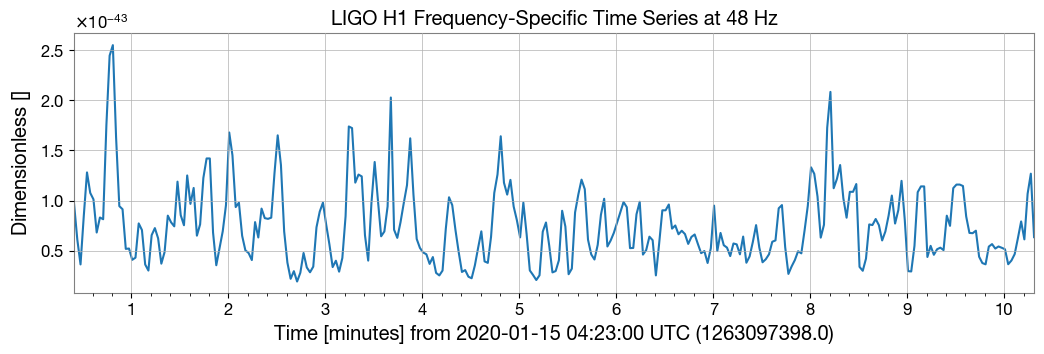

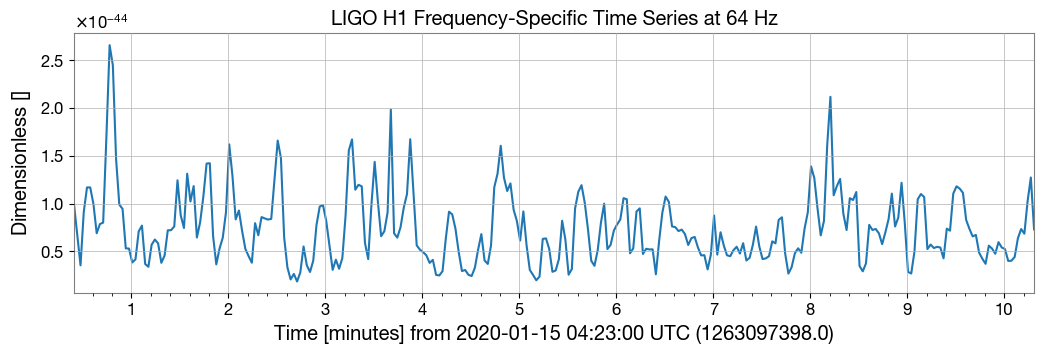

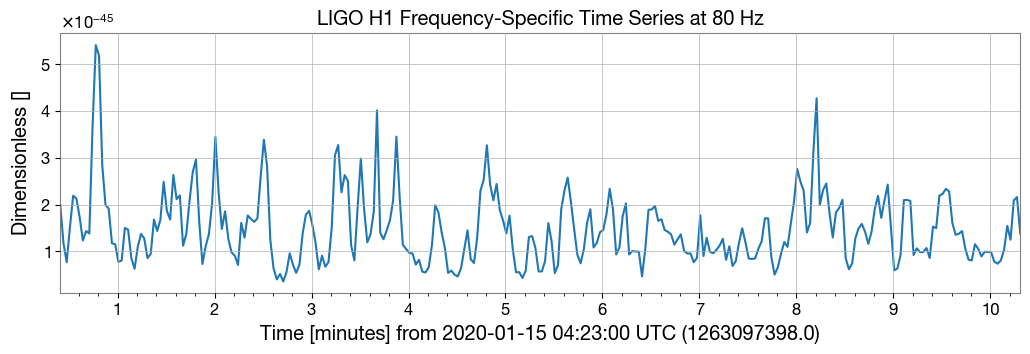

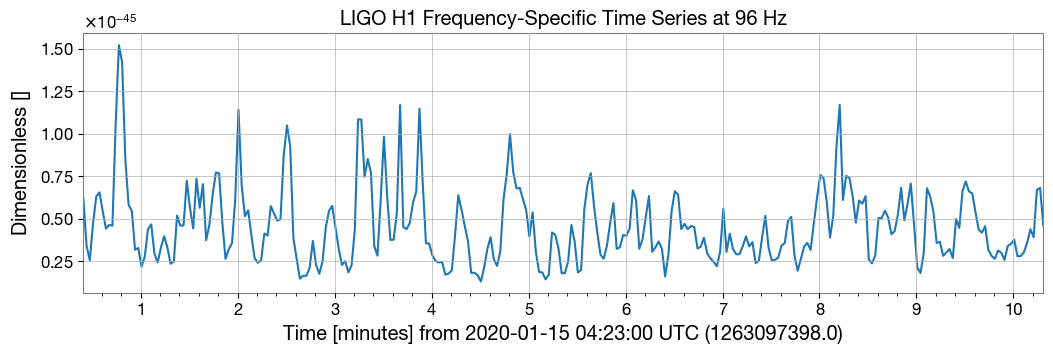

In [5]:
i = 16
while i < 100:
    plot_fss_at_freq(i)
    i += 16

The the plots certainly seem to have almost identical features, ignoring the different y-axis scales. Normalizing yields:

In [6]:
def plot_normalized_fss_at_freq(frequency):
    fss = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, frequency)
    fss = fss / np.median(fss)
    plot1 = fss.plot()
    ax1 = plot1.gca()
    ax1.set_title(f'Normalized LIGO H1 Frequency-Specific Time Series at {frequency} Hz')
    plot1.show()

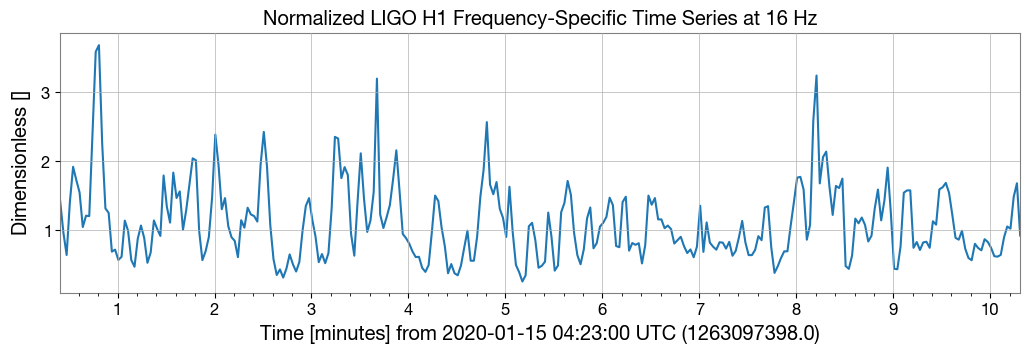

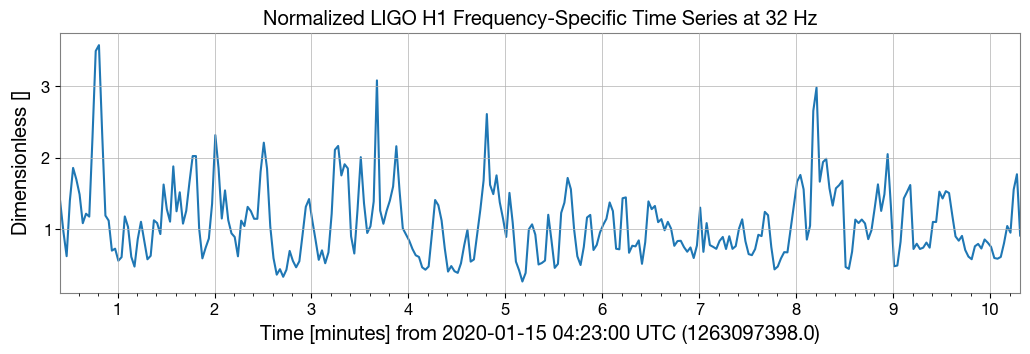

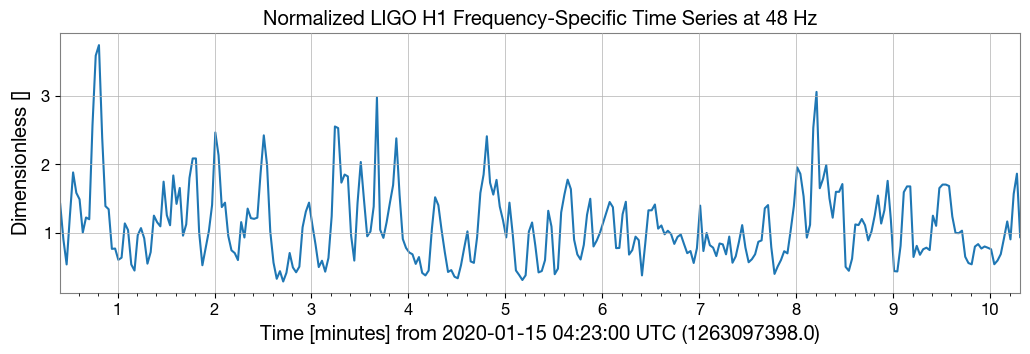

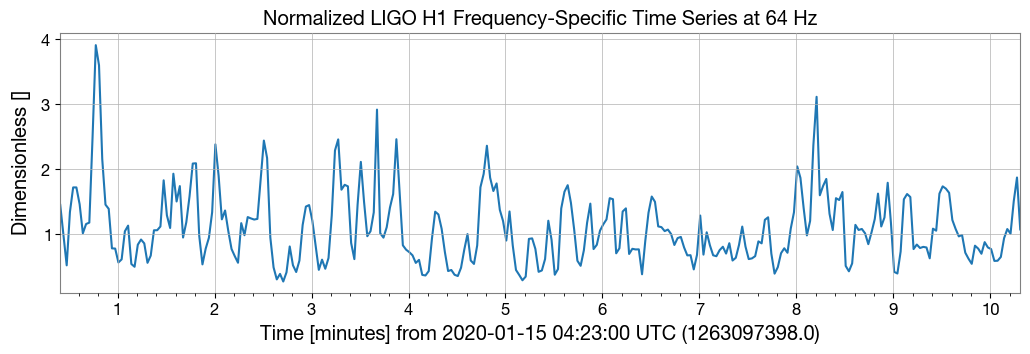

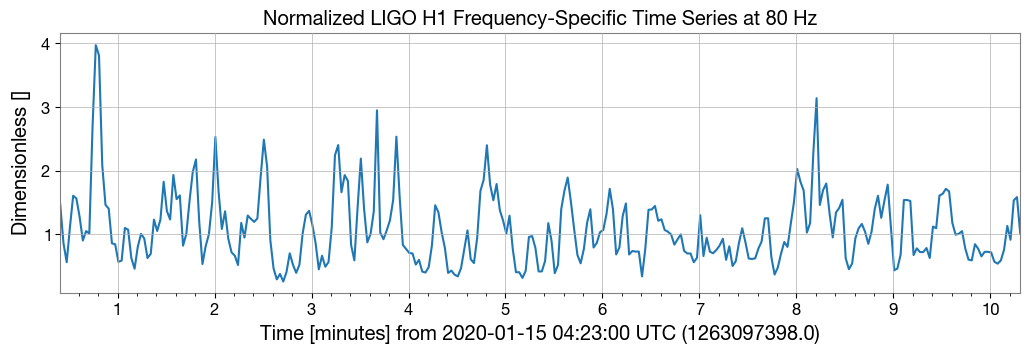

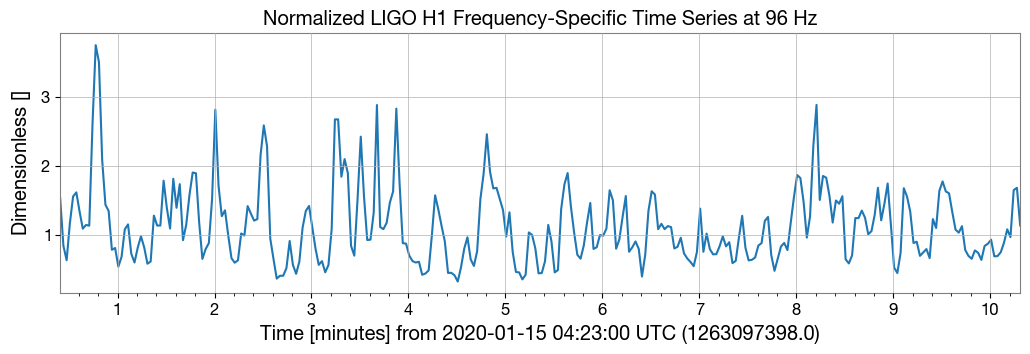

In [7]:
i = 16
while i < 100:
    plot_normalized_fss_at_freq(i)
    i += 16

How well do these five arrays correlate with each other? I'll create a correlation matrix where $C_{ij}$ is the correlation between array $i$ and $j$, where the values of $i$ and $j$ map to:
- 1: 16 Hz
- 2: 32 Hz
- 3: 48 Hz
- 4: 64 Hz
- 5: 80 Hz
- 6: 96 Hz

In [8]:
fss16 = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, 16)
normalized_fss16 = fss16 / np.amax(fss16)

fss32 = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, 32)
normalized_fss32 = fss32 / np.amax(fss32)

fss48 = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, 48)
normalized_fss48 = fss48 / np.amax(fss48)

fss64 = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, 64)
normalized_fss64 = fss64 / np.amax(fss64)

fss80 = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, 80)
normalized_fss80 = fss80 / np.amax(fss80)

fss96 = freq_specific_time_series(hdata1, min_time1, 5, 2, max_time1, 96)
normalized_fss96 = fss96 / np.amax(fss96)

In [9]:
data1 = np.column_stack((normalized_fss16.value, normalized_fss32.value, normalized_fss48.value, normalized_fss64.value, normalized_fss80.value, normalized_fss96.value))
corr_matrix1 = np.corrcoef(data1, rowvar = False) # Compute matrix form Pearson product-moment correlation coefficients (R)
                                                # Should I use Spearman instead? Are the variables normally distributed?
np.set_printoptions(precision=3)
print(corr_matrix1)

[[1.    0.994 0.99  0.985 0.977 0.971]
 [0.994 1.    0.984 0.977 0.97  0.964]
 [0.99  0.984 1.    0.99  0.983 0.977]
 [0.985 0.977 0.99  1.    0.989 0.982]
 [0.977 0.97  0.983 0.989 1.    0.983]
 [0.971 0.964 0.977 0.982 0.983 1.   ]]


The noise levels at the different frequencies are highly correlated, with any given correlation $C_{ij}$ having a value of at least 0.97 or higher. **Question:** Should I do hypothesis testing to determine whether these levels are statistically significant? If so, how?

## Adjacent Time Slices

How does this pattern change with adjacent time slices?

In [10]:
# Next 10 mins
min_time2 = 1263098020
max_time2 = 1263098620
hdata2 = TimeSeries.fetch_open_data('H1', min_time2, max_time2)

In [11]:
fss16_set2 = freq_specific_time_series(hdata2, min_time2, 5, 2, max_time2, 16)
normalized_fss16_set2 = fss16_set2 / np.amax(fss16_set2)

fss32_set2 = freq_specific_time_series(hdata2, min_time2, 5, 2, max_time2, 32)
normalized_fss32_set2 = fss32_set2 / np.amax(fss32_set2)

fss48_set2 = freq_specific_time_series(hdata2, min_time2, 5, 2, max_time2, 48)
normalized_fss48_set2 = fss48_set2 / np.amax(fss48_set2)

fss64_set2 = freq_specific_time_series(hdata2, min_time2, 5, 2, max_time2, 64)
normalized_fss64_set2 = fss64_set2 / np.amax(fss64_set2)

fss80_set2 = freq_specific_time_series(hdata2, min_time2, 5, 2, max_time2, 80)
normalized_fss80_set2 = fss80_set2 / np.amax(fss80_set2)

fss96_set2 = freq_specific_time_series(hdata2, min_time2, 5, 2, max_time2, 96)
normalized_fss96_set2 = fss96_set2 / np.amax(fss96_set2)

In [12]:
data2 = np.column_stack((normalized_fss16_set2.value, normalized_fss32_set2.value, normalized_fss48_set2.value, normalized_fss64_set2.value, normalized_fss80_set2.value, normalized_fss96_set2.value))
corr_matrix2 = np.corrcoef(data2, rowvar = False) # Compute matrix form Pearson product-moment correlation coefficients (R)
                                                # Should I use Spearman instead? Are the variables normally distributed?
np.set_printoptions(precision=3)
print(corr_matrix2)

[[1.    0.992 0.986 0.982 0.97  0.963]
 [0.992 1.    0.978 0.973 0.961 0.958]
 [0.986 0.978 1.    0.991 0.982 0.972]
 [0.982 0.973 0.991 1.    0.984 0.978]
 [0.97  0.961 0.982 0.984 1.    0.974]
 [0.963 0.958 0.972 0.978 0.974 1.   ]]


In [13]:
# Next next 10 mins
min_time3 = 1263098620
max_time3 = 1263099220
hdata3 = TimeSeries.fetch_open_data('H1', min_time3, max_time3)

In [14]:
fss16_set3 = freq_specific_time_series(hdata3, min_time3, 5, 2, max_time3, 16)
normalized_fss16_set3 = fss16_set3 / np.amax(fss16_set3)

fss32_set3 = freq_specific_time_series(hdata3, min_time3, 5, 2, max_time3, 32)
normalized_fss32_set3 = fss32_set3 / np.amax(fss32_set3)

fss48_set3 = freq_specific_time_series(hdata3, min_time3, 5, 2, max_time3, 48)
normalized_fss48_set3 = fss48_set3 / np.amax(fss48_set3)

fss64_set3 = freq_specific_time_series(hdata3, min_time3, 5, 2, max_time3, 64)
normalized_fss64_set3 = fss64_set3 / np.amax(fss64_set3)

fss80_set3 = freq_specific_time_series(hdata3, min_time3, 5, 2, max_time3, 80)
normalized_fss80_set3 = fss80_set3 / np.amax(fss80_set3)

fss96_set3 = freq_specific_time_series(hdata3, min_time3, 5, 2, max_time3, 96)
normalized_fss96_set3 = fss96_set3 / np.amax(fss96_set3)

In [15]:
data3 = np.column_stack((normalized_fss16_set3.value, normalized_fss32_set3.value, normalized_fss48_set3.value, normalized_fss64_set3.value, normalized_fss80_set3.value, normalized_fss96_set3.value))
corr_matrix3 = np.corrcoef(data3, rowvar = False) # Compute matrix form Pearson product-moment correlation coefficients (R)
                                                # Should I use Spearman instead? Are the variables normally distributed?
np.set_printoptions(precision=3)
print(corr_matrix3)

[[1.    0.994 0.992 0.985 0.98  0.97 ]
 [0.994 1.    0.986 0.974 0.971 0.956]
 [0.992 0.986 1.    0.991 0.986 0.975]
 [0.985 0.974 0.991 1.    0.989 0.983]
 [0.98  0.971 0.986 0.989 1.    0.981]
 [0.97  0.956 0.975 0.983 0.981 1.   ]]


In [16]:
print('First dataset:')
print(corr_matrix1)
print('\nSecond dataset:')
print(corr_matrix2)
print('\nThird dataset:')
print(corr_matrix3)

First dataset:
[[1.    0.994 0.99  0.985 0.977 0.971]
 [0.994 1.    0.984 0.977 0.97  0.964]
 [0.99  0.984 1.    0.99  0.983 0.977]
 [0.985 0.977 0.99  1.    0.989 0.982]
 [0.977 0.97  0.983 0.989 1.    0.983]
 [0.971 0.964 0.977 0.982 0.983 1.   ]]

Second dataset:
[[1.    0.992 0.986 0.982 0.97  0.963]
 [0.992 1.    0.978 0.973 0.961 0.958]
 [0.986 0.978 1.    0.991 0.982 0.972]
 [0.982 0.973 0.991 1.    0.984 0.978]
 [0.97  0.961 0.982 0.984 1.    0.974]
 [0.963 0.958 0.972 0.978 0.974 1.   ]]

Third dataset:
[[1.    0.994 0.992 0.985 0.98  0.97 ]
 [0.994 1.    0.986 0.974 0.971 0.956]
 [0.992 0.986 1.    0.991 0.986 0.975]
 [0.985 0.974 0.991 1.    0.989 0.983]
 [0.98  0.971 0.986 0.989 1.    0.981]
 [0.97  0.956 0.975 0.983 0.981 1.   ]]


The trend seems to hold across these three time slices! What about for a non-adjacent time slice?

In [17]:
# Getting data
min_time4 = 1239062662
max_time4 = 1239063262
hdata4 = TimeSeries.fetch_open_data('H1', min_time4, max_time4)

In [18]:
fss16_set4 = freq_specific_time_series(hdata4, min_time4, 5, 2, max_time4, 16)
normalized_fss16_set4 = fss16_set4 / np.amax(fss16_set4)

fss32_set4 = freq_specific_time_series(hdata4, min_time4, 5, 2, max_time4, 32)
normalized_fss32_set4 = fss32_set4 / np.amax(fss32_set4)

fss48_set4 = freq_specific_time_series(hdata4, min_time4, 5, 2, max_time4, 48)
normalized_fss48_set4 = fss48_set4 / np.amax(fss48_set4)

fss64_set4 = freq_specific_time_series(hdata4, min_time4, 5, 2, max_time4, 64)
normalized_fss64_set4 = fss64_set4 / np.amax(fss64_set4)

fss80_set4 = freq_specific_time_series(hdata4, min_time4, 5, 2, max_time4, 80)
normalized_fss80_set4 = fss80_set4 / np.amax(fss80_set4)

fss96_set4 = freq_specific_time_series(hdata4, min_time4, 5, 2, max_time4, 96)
normalized_fss96_set4 = fss96_set4 / np.amax(fss96_set4)

In [19]:
data4 = np.column_stack((normalized_fss16_set4.value, normalized_fss32_set4.value, normalized_fss48_set4.value, normalized_fss64_set4.value, normalized_fss80_set4.value, normalized_fss96_set4.value))
corr_matrix4 = np.corrcoef(data4, rowvar = False) # Compute matrix form Pearson product-moment correlation coefficients (R)
                                                # Should I use Spearman instead? Are the variables normally distributed?
np.set_printoptions(precision=3)
print(corr_matrix4)

[[1.    0.915 0.961 0.912 0.888 0.883]
 [0.915 1.    0.846 0.781 0.75  0.745]
 [0.961 0.846 1.    0.96  0.943 0.932]
 [0.912 0.781 0.96  1.    0.982 0.974]
 [0.888 0.75  0.943 0.982 1.    0.979]
 [0.883 0.745 0.932 0.974 0.979 1.   ]]


In [20]:
# Getting data
min_time5 = 1239063262
max_time5 = 1239063862
hdata5 = TimeSeries.fetch_open_data('H1', min_time5, max_time5)

In [21]:
fss16_set5 = freq_specific_time_series(hdata5, min_time5, 5, 2, max_time5, 16)
normalized_fss16_set5 = fss16_set5 / np.amax(fss16_set5)

fss32_set5 = freq_specific_time_series(hdata5, min_time5, 5, 2, max_time5, 32)
normalized_fss32_set5 = fss32_set5 / np.amax(fss32_set5)

fss48_set5 = freq_specific_time_series(hdata5, min_time5, 5, 2, max_time5, 48)
normalized_fss48_set5 = fss48_set5 / np.amax(fss48_set5)

fss64_set5 = freq_specific_time_series(hdata5, min_time5, 5, 2, max_time5, 64)
normalized_fss64_set5 = fss64_set5 / np.amax(fss64_set5)

fss80_set5 = freq_specific_time_series(hdata5, min_time5, 5, 2, max_time5, 80)
normalized_fss80_set5 = fss80_set5 / np.amax(fss80_set5)

fss96_set5 = freq_specific_time_series(hdata5, min_time5, 5, 2, max_time5, 96)
normalized_fss96_set5 = fss96_set5 / np.amax(fss96_set5)

In [22]:
data5 = np.column_stack((normalized_fss16_set5.value, normalized_fss32_set5.value, normalized_fss48_set5.value, normalized_fss64_set5.value, normalized_fss80_set5.value, normalized_fss96_set5.value))
corr_matrix5 = np.corrcoef(data5, rowvar = False) # Compute matrix form Pearson product-moment correlation coefficients (R)
                                                # Should I use Spearman instead? Are the variables normally distributed?
np.set_printoptions(precision=3)
print(corr_matrix5)

[[1.    0.934 0.972 0.923 0.89  0.881]
 [0.934 1.    0.886 0.823 0.789 0.774]
 [0.972 0.886 1.    0.963 0.94  0.932]
 [0.923 0.823 0.963 1.    0.984 0.974]
 [0.89  0.789 0.94  0.984 1.    0.979]
 [0.881 0.774 0.932 0.974 0.979 1.   ]]


In [23]:
print('First dataset:')
print(corr_matrix4)
print('\nSecond dataset:')
print(corr_matrix5)

First dataset:
[[1.    0.915 0.961 0.912 0.888 0.883]
 [0.915 1.    0.846 0.781 0.75  0.745]
 [0.961 0.846 1.    0.96  0.943 0.932]
 [0.912 0.781 0.96  1.    0.982 0.974]
 [0.888 0.75  0.943 0.982 1.    0.979]
 [0.883 0.745 0.932 0.974 0.979 1.   ]]

Second dataset:
[[1.    0.934 0.972 0.923 0.89  0.881]
 [0.934 1.    0.886 0.823 0.789 0.774]
 [0.972 0.886 1.    0.963 0.94  0.932]
 [0.923 0.823 0.963 1.    0.984 0.974]
 [0.89  0.789 0.94  0.984 1.    0.979]
 [0.881 0.774 0.932 0.974 0.979 1.   ]]


## Root Mean Square Deviation

How does the root mean square deviation compare among the frequency time series?

For next time:
- Normalize time series with respect to the median or mean instead of the max **(done)**
- Calculate RMS of normalized band time series
- Look more into the 304 Hz